In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')




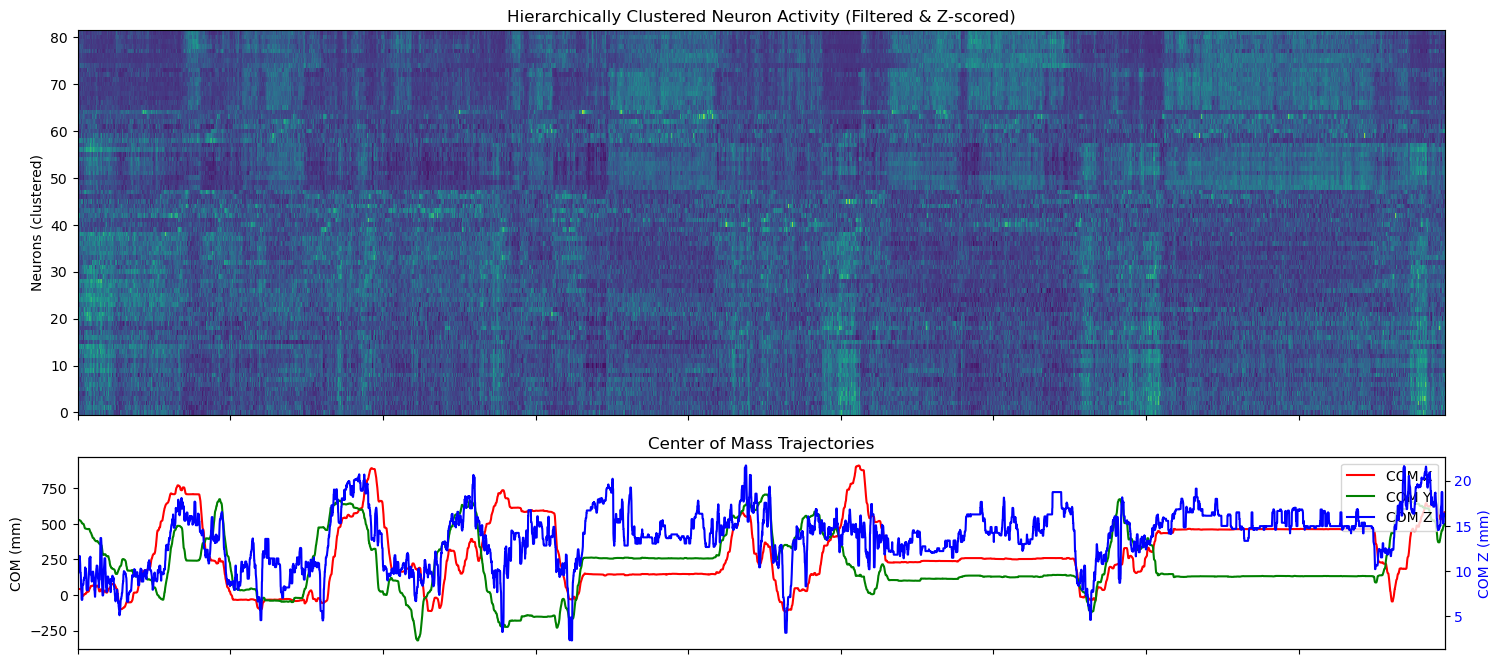

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

df_new = df_merged_with_dF_F

df_new = df_new.reset_index()


time = df_new['timestamp_ms_mini']

# --- Figure & GridSpec ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1, 1.5])  # Adjusted for 3 plots

###########################################
# Plot 1 (row 0): Ca²⁺ Heatmap
###########################################
ax1 = fig.add_subplot(gs[0, 0])
if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
    # Hierarchical clustering
    Z = linkage(neuron_activity_normalized, method='ward')
    neuron_order = leaves_list(Z)  # Leaves from dendrogram
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    # Plot heatmap with pcolormesh
    neuron_indices = np.arange(len(neuron_activity_ordered))
    mesh = ax1.pcolormesh(
        time, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )
    ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax1.set_ylabel('Neurons (clustered)')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax1.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('No Neuron Activity Plot')
ax1.tick_params(labelbottom=False)

###########################################
# Plot 2 (row 1): COM Trajectories
###########################################
# ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
#     ax2.plot(time, df_new['com_x'], color='red', label='COM X')
#     ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
#     ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
#     ax2.set_ylabel('COM (mm)')
#     ax2.set_title('Center of Mass Trajectories')
#     ax2.legend(loc='upper right')  # Adjust legend position
# else:
#     print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
# ax2.tick_params(labelbottom=False)


ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    ax2.plot(time, df_new['com_x'], color='red', label='COM X')
    ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax2.set_ylabel('COM (mm)')
    ax2.set_title('Center of Mass Trajectories')
    
    # Create a secondary y-axis for COM Z
    ax2_right = ax2.twinx()
    ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax2_right.set_ylabel('COM Z (mm)', color='blue')
    ax2_right.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends from both axes
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
    ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")

ax2.tick_params(labelbottom=False)



###########################################
# Plot 3 (row 2): Head Orientation
###########################################
# ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
# if {'head_pitch', 'head_yaw', 'head_roll'}.issubset(head_coords.columns):
#     ax3.plot(time, head_coords['head_pitch'], label='Head Pitch', color='blue')
#     ax3.plot(time, head_coords['head_yaw'], label='Head Yaw', color='green')
#     ax3.plot(time, head_coords['head_roll'], label='Head Roll', color='red')
#     ax3.set_ylabel('Head Orientation (degrees)')
#     ax3.set_title('Head Orientation Over Time')
#     ax3.legend(loc='upper right')
# else:
#     print("Head orientation columns not found (head_pitch, head_yaw, head_roll). Check your DataFrame.")

# Final Adjustments
# ax3.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()



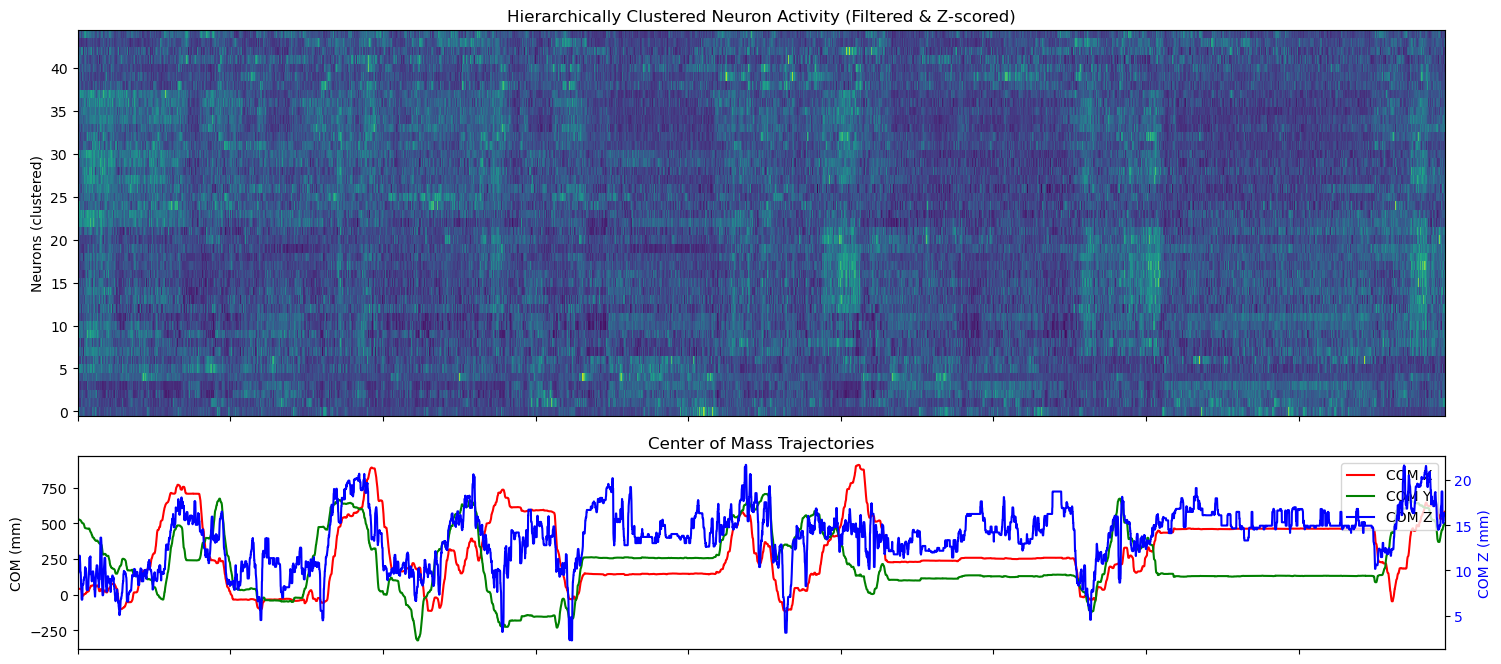

In [7]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
import os
import sys
sys.path.append(os.path.abspath('../..'))

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'
hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# ------------------------------
# Exclude specific neurons
# ------------------------------
exclude_indices = [62,68,71,72,73,23,24,25,1,3,8,46,75,78,55,11,56,18,84,10,77,76,74,7,2,9,17,10,12,14,15,16,18,19,13,17,0,20,60,63,70,79]
manual_excluded_neurons = [f'dF_F_roi{i}' for i in exclude_indices]

# Extract columns corresponding to neurons, excluding the ones we want to leave out
neuron_columns = [
    col for col in df_merged_with_dF_F.columns 
    if col.startswith('dF_F_roi') and col not in manual_excluded_neurons
]

# ------------------------------
# Proceed with the analysis
# ------------------------------
# Extract the neuron activity data (timepoints x neurons)
neuron_activity = df_merged_with_dF_F[neuron_columns].values

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)
threshold = np.percentile(neuron_variances, 5)  # Keep top 95% variance
high_variance_indices = neuron_variances > threshold

# Filter neuron activity and neuron column names accordingly
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Z-score normalization along each neuron's time course (optional)
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)

# Hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='complete', metric='euclidean')

# ------------------------------
# Plotting code (example below)
# ------------------------------
df_new = df_merged_with_dF_F.reset_index()
time = df_new['timestamp_ms_mini']

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1, 1.5])

# Plot 1: Ca²⁺ Heatmap of clustered neuron activity
ax1 = fig.add_subplot(gs[0, 0])
if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
    # Perform hierarchical clustering (using ward linkage for the heatmap)
    Z = linkage(neuron_activity_normalized, method='ward')
    neuron_order = leaves_list(Z)
    neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
    ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

    neuron_indices = np.arange(len(neuron_activity_ordered))
    mesh = ax1.pcolormesh(
        time, neuron_indices, neuron_activity_ordered,
        cmap='viridis', shading='auto'
    )
    ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
    ax1.set_ylabel('Neurons (clustered)')
else:
    print("Neuron activity data not found. Skipping heatmap plot.")
    ax1.text(0.5, 0.5, 'No neuron activity data available.',
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('No Neuron Activity Plot')
ax1.tick_params(labelbottom=False)

# Plot 2: COM Trajectories
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    ax2.plot(time, df_new['com_x'], color='red', label='COM X')
    ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
    ax2.set_ylabel('COM (mm)')
    ax2.set_title('Center of Mass Trajectories')
    
    # Create a secondary y-axis for COM Z
    ax2_right = ax2.twinx()
    ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
    ax2_right.set_ylabel('COM Z (mm)', color='blue')
    ax2_right.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends from both axes
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
    ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='upper right')
else:
    print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
ax2.tick_params(labelbottom=False)

# If you have additional plots (e.g., head orientation), integrate them here
plt.tight_layout()
plt.show()


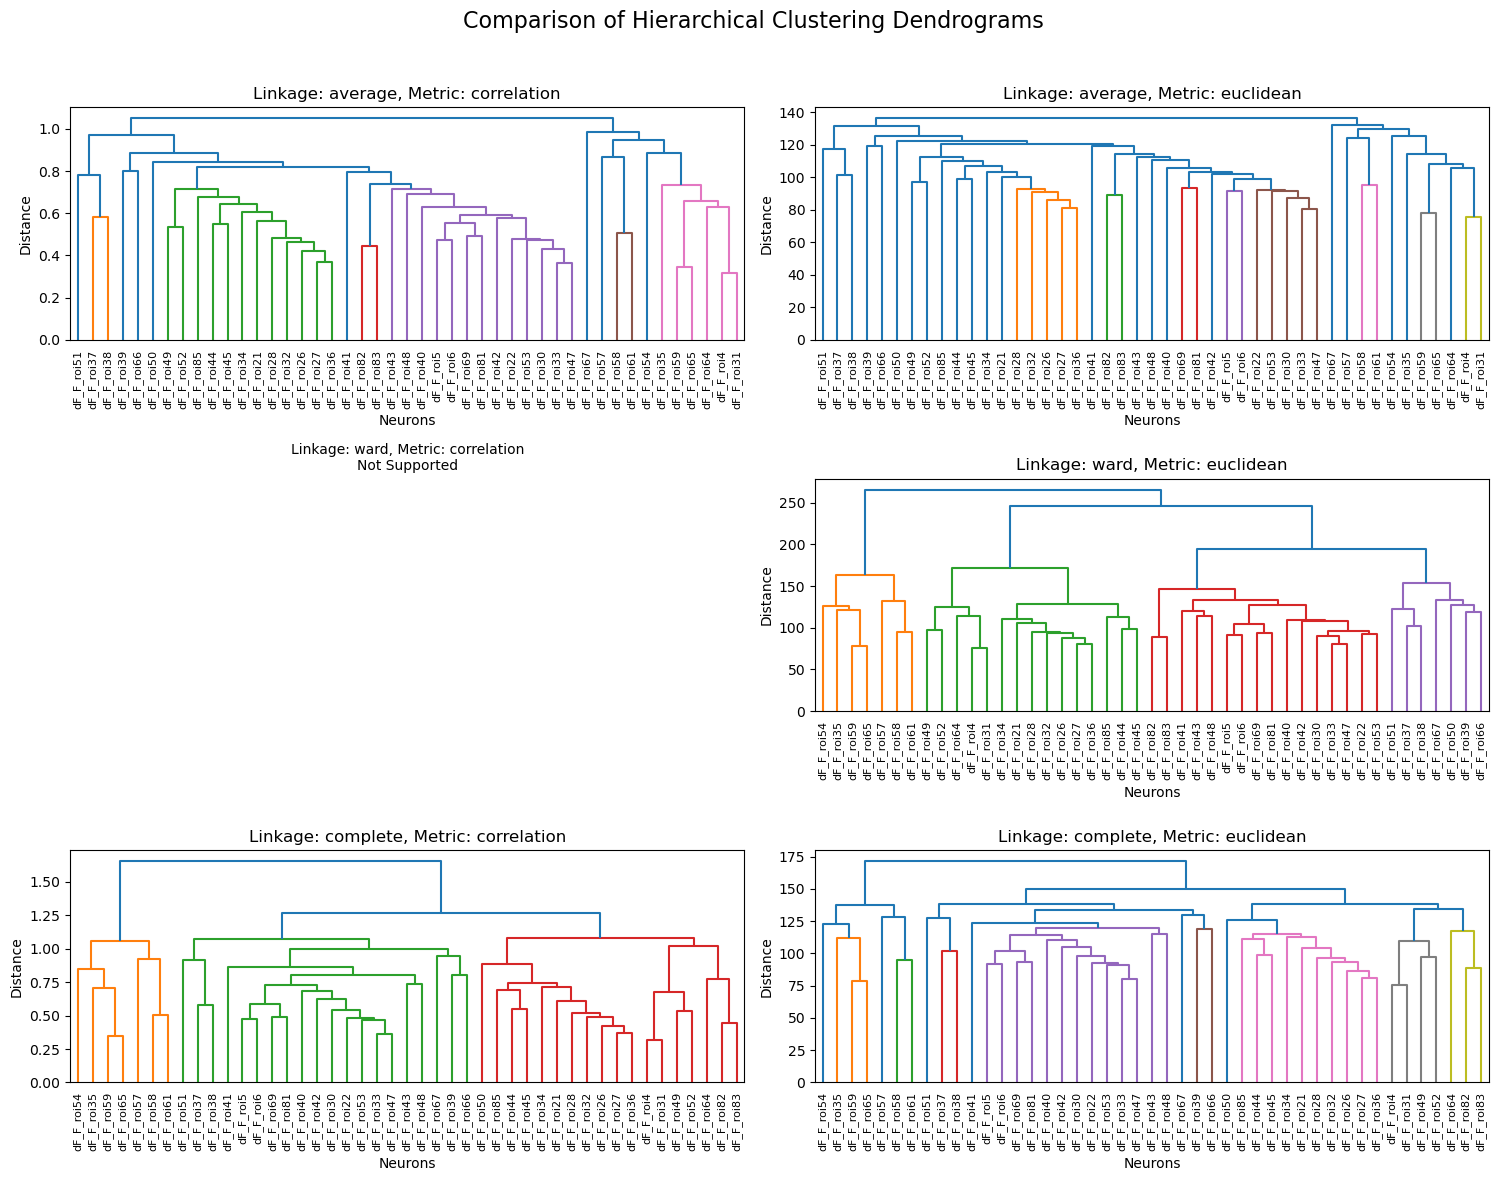

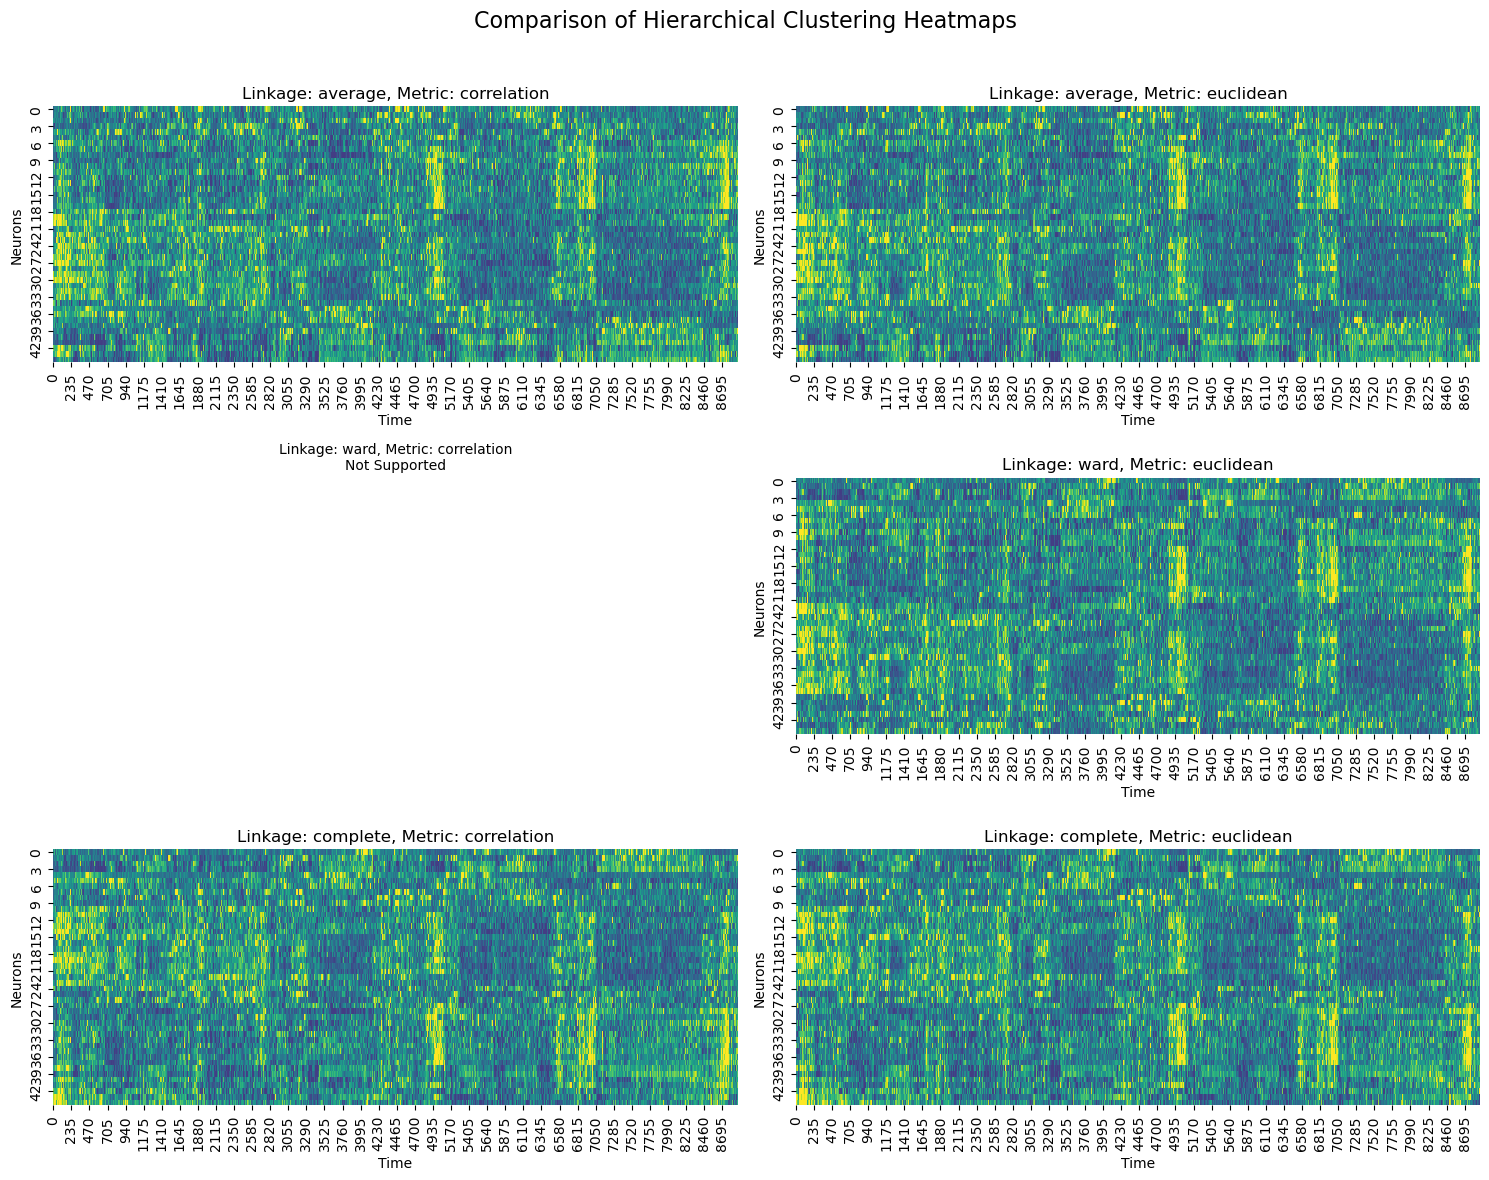

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore

# ------------------------------
# Exclude specific neurons
# ------------------------------
exclude_indices = [62,68,71,72,73,23,24,25,1,3,8,46,75,78,55,11,56,18,84,10,77,76,74,7,2,9,17,10,12,14,15,16,18,19,13,17,0,20,60,63,70,79]
manual_excluded_neurons = [f'dF_F_roi{i}' for i in exclude_indices]

# ------------------------------
# Extract neuron columns (excluding the ones in manual_excluded_neurons)
# ------------------------------
neuron_columns = [
    col for col in df_merged_with_dF_F.columns 
    if col.startswith('dF_F_roi') and col not in manual_excluded_neurons
]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# ------------------------------
# Drop low-variance neurons (reduce false positives)
# ------------------------------
neuron_variances = np.var(neuron_activity, axis=1)
threshold = np.percentile(neuron_variances, 5)  # Keeping top 95% variance
high_variance_indices = neuron_variances > threshold

# Filter neuron activity and column names accordingly
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# ------------------------------
# Z-score normalization along each neuron's time course
# ------------------------------
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)

# ------------------------------
# Define distance metrics and linkage methods to test
# ------------------------------
distance_metrics = ['correlation', 'euclidean']
linkage_methods = ['average', 'ward', 'complete']

# ------------------------------
# Dendrogram Comparison
# ------------------------------
fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(15, 12))
fig.suptitle('Comparison of Hierarchical Clustering Dendrograms', fontsize=16)

for i, method in enumerate(linkage_methods):
    for j, metric in enumerate(distance_metrics):
        if method == 'ward' and metric != 'euclidean':
            # Skip incompatible combinations
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Linkage: {method}, Metric: {metric}\nNot Supported", fontsize=10)
            continue
        
        # Perform hierarchical clustering
        Z = linkage(neuron_activity_normalized, method=method, metric=metric)
        
        # Plot the dendrogram
        ax = axes[i, j]
        dendrogram(Z, labels=filtered_neuron_columns, leaf_rotation=90, ax=ax, no_plot=False)
        ax.set_title(f"Linkage: {method}, Metric: {metric}")
        ax.set_xlabel('Neurons')
        ax.set_ylabel('Distance')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ------------------------------
# Hierarchical Clustering Heatmap Comparison
# ------------------------------
fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(15, 12))
fig.suptitle('Comparison of Hierarchical Clustering Heatmaps', fontsize=16)

for i, method in enumerate(linkage_methods):
    for j, metric in enumerate(distance_metrics):
        if method == 'ward' and metric != 'euclidean':
            # Skip incompatible combinations
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Linkage: {method}, Metric: {metric}\nNot Supported", fontsize=10)
            continue
        
        # Perform hierarchical clustering
        Z = linkage(neuron_activity_normalized, method=method, metric=metric)
        neuron_order = leaves_list(Z)
        
        # Reorder the data based on the clustering result
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[k] for k in neuron_order]
        
        # Plot the heatmap
        ax = axes[i, j]
        sns.heatmap(neuron_activity_ordered, cmap='viridis', center=0, robust=True, ax=ax, cbar=False)
        ax.set_title(f"Linkage: {method}, Metric: {metric}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Neurons')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
